In [1]:
# Description:
# This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
# to predict the closing stock price of a corporation (Apple Inc.) using the past 60 day stock price.

In [2]:
#Import the libraries
from datetime import datetime, timedelta
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# configuration
tickers = ['MSFT',
           '^GSPC', # S&P 500
#            'AAPL',
#            'AMZN',
#            'GOOG',
           'EXPE', # MSFT CUSTOMER
#            'FB',
           'BA', # MSFT CUSTOMER
           'SSNLF', # MSFT CUSTOMER
           'GE', # MSFT CUSTOMER
           'BMWYY' # MSFT CUSTOMER \
#            'INTC',
#            'NVDA',
#            'PYPL',
#            'CRM', \
#            'TSLA',
#            'AMD',
#            'ATVI',
#            'EA',
#            'MTCH',
#            'TTD',
#            'ZG',
#            'YELP',
#            'TIVO' \
          ]

# ticker = tickers[0]
data_source='yahoo'

today = datetime.strftime(datetime.today(), '%Y-%m-%d')

start='2010-01-01'
train_end_t_minus = 1 
end=(datetime.strftime(datetime.now() - timedelta(train_end_t_minus), '%Y-%m-%d'))
predict_n = 10
memory = 60
Y = 'MSFT'

print(" TICKERS:\n\t", '\n\t '.join(map(str, tickers)),
    "\n Today's date:", today, "\n",
      "Model will train on timewindow:" ,
      "\n\t from %s" %start,
      "\n\t from %s" %end,
     "\n model will predict %s period steps in the future" %predict_n)

 TICKERS:
	 MSFT
	 ^GSPC
	 EXPE
	 BA
	 SSNLF
	 GE
	 BMWYY 
 Today's date: 2020-04-26 
 Model will train on timewindow: 
	 from 2010-01-01 
	 from 2020-04-25 
 model will predict 10 period steps in the future


In [4]:
# #Get the stock quote 
# df = web.DataReader(ticker, data_source=data_source, start=start, end=end) 
# #Show the data 
# df.shape, df.head()


#Get the stock quote 
df_o = pd.DataFrame()

for ticker in tickers:
    d=(web.DataReader(ticker, data_source=data_source, start=start, end=end).reset_index()[['Date', 'Close', 'Open']])
    d = d.rename(columns={"Close": "C_" + ticker, "Open": 'O_' + ticker})
    if df_o.empty:
        df_o=d
    else:
        df_o = pd.merge(df_o,d, on='Date')
        
    
    
# #Show the data 
# # print(df.shape)
df_o = df_o.set_index('Date')
df_o.shape

(1976, 14)

In [5]:
s1 = df_o.reset_index().melt(id_vars='Date')
s1['ticker'] = s1['variable'].str[2:]
s1['day_part'] = s1['variable'].str[0:1]
# s1
s1 = s1.pivot_table(index=['Date', 'day_part'], columns='ticker', values = 'value').reset_index()
# s1['date'] = s1['Date']
s1.loc[s1['day_part'] == "O",'Date'] = s1.loc[s1['day_part'] == "O", 'Date'] + pd.DateOffset(hours=9, minutes=30)
s1.loc[s1['day_part'] == "C",'Date'] = s1.loc[s1['day_part'] == "C", 'Date'] + pd.DateOffset(hours=16, minutes = 0)

df = s1.sort_values(by=['Date'])
# df = df.reset_index()
df = df.drop(['day_part'], axis=1)
df = df.set_index('Date').reset_index()
# df.set_index('Date')

In [6]:
# s1.Date+datetime
df.head()

ticker,Date,BA,BMWYY,EXPE,GE,MSFT,SSNLF,^GSPC
0,2012-06-18 09:30:00,71.690002,23.809999,49.950001,19.115385,29.990000,20.0,1342.420044
1,2012-06-18 16:00:00,71.900002,23.879999,49.959999,18.990385,29.840000,20.0,1344.780029
2,2012-06-19 09:30:00,72.360001,24.200001,48.700001,19.105770,30.190001,20.0,1344.829956
3,2012-06-19 16:00:00,72.919998,24.540001,48.490002,19.230770,30.700001,20.0,1357.979980
4,2012-06-20 09:30:00,72.699997,24.459999,48.560001,19.230770,30.930000,20.0,1358.040039


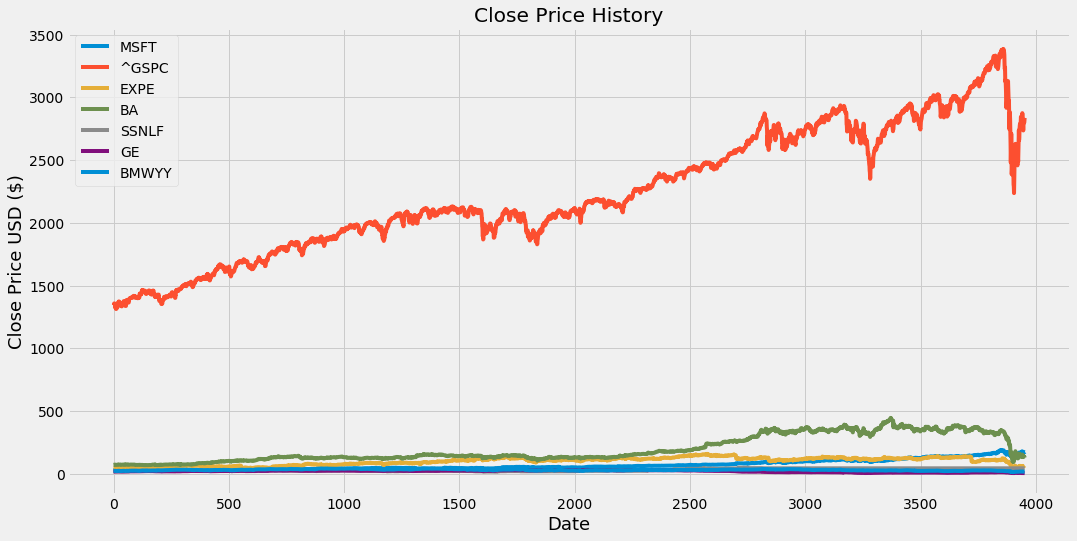

In [7]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
# plt.plot(df['Close'])
plt.plot(df[tickers])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend(tickers)
plt.show()

In [8]:
#Create a new dataframe with only the 'Close' column
# data = df.filter(['Close'])
dataset = df[tickers]
#Converting the dataframe to a numpy array
# dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [9]:
#Scale the all of the data to be values between 0 and 1 
x_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = dataset[tickers]

# for ticker in tickers:
y_scaler.fit(scaled_data[Y].values.reshape(-1,1))
scaled_data[tickers] = x_scaler.fit_transform(scaled_data[tickers])
# scaled_data[Y] = y_scaler.fit_transform(dataset[Y].values.reshape(-1,1)).reshape(-1)
# scaled_data['Close_MSFT'] = y_scaler.fit_transform(dataset['Close_MSFT'].values.reshape(-1,1)).reshape(-1)


In [10]:
scaled_data.head(), dataset.head()
# df[tickers]
# scaled_data.head()

(ticker      MSFT     ^GSPC      EXPE        BA    SSNLF        GE     BMWYY
 0       0.022036  0.013849  0.051022  0.006239  0.09375  0.508374  0.347710
 1       0.021122  0.014987  0.051109  0.006796  0.09375  0.503488  0.350050
 2       0.023253  0.015011  0.040194  0.008018  0.09375  0.507998  0.360749
 3       0.026357  0.021357  0.038375  0.009504  0.09375  0.512885  0.372116
 4       0.027757  0.021386  0.038981  0.008920  0.09375  0.512885  0.369442,
 ticker       MSFT        ^GSPC       EXPE         BA  SSNLF         GE  \
 0       29.990000  1342.420044  49.950001  71.690002   20.0  19.115385   
 1       29.840000  1344.780029  49.959999  71.900002   20.0  18.990385   
 2       30.190001  1344.829956  48.700001  72.360001   20.0  19.105770   
 3       30.700001  1357.979980  48.490002  72.919998   20.0  19.230770   
 4       30.930000  1358.040039  48.560001  72.699997   20.0  19.230770   
 
 ticker      BMWYY  
 0       23.809999  
 1       23.879999  
 2       24.200001  
 

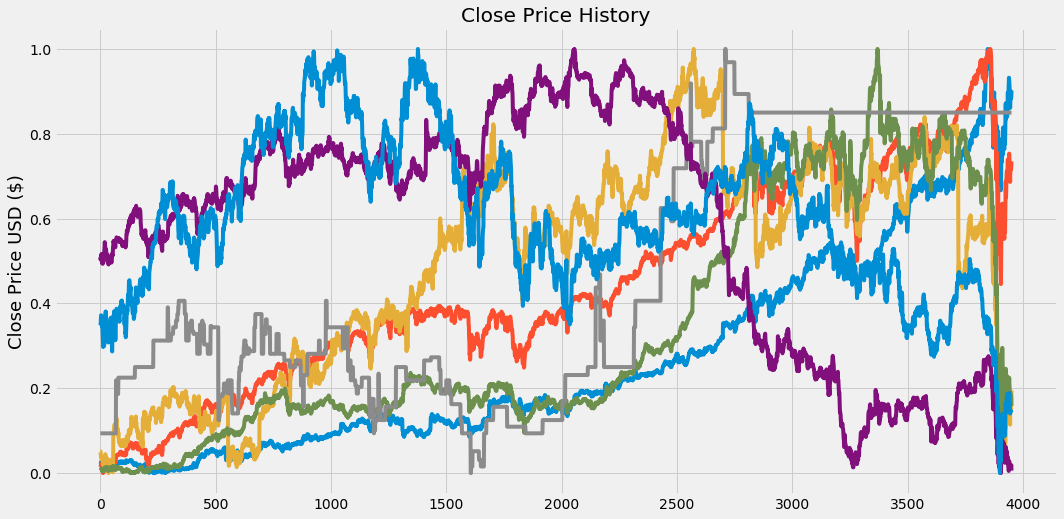

In [11]:
# scaled_data.values

#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
# plt.plot(df['Close'])
plt.plot(scaled_data[tickers])
# plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [12]:
scaled_data = scaled_data.values

In [13]:
#Create the scaled training data set 


train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-memory:i,:])
    y_train.append(train_data[i,0])



# train_data = scaled_data[0:training_data_len  , : ]
# #Split the data into x_train and y_train data sets
# x_train=[]
# y_train = []
# for i in range(60,len(train_data)):
#     x_train.append(train_data[i-memory:i,:])
#     y_train.append(train_data[i,'MSFT'])

In [14]:
x_train[2][-5:], y_train[:5]

(array([[0.0206355 , 0.03486246, 0.0939016 , 0.0163804 , 0.09375   ,
         0.54746369, 0.37178204],
        [0.02057462, 0.03484797, 0.0939016 , 0.01396448, 0.09375   ,
         0.5425775 , 0.36977598],
        [0.01990503, 0.0345392 , 0.10446983, 0.01465475, 0.09375   ,
         0.54295335, 0.37245067],
        [0.01893109, 0.03452471, 0.10031183, 0.01454855, 0.09375   ,
         0.54107405, 0.38181211],
        [0.01887021, 0.03165365, 0.11200624, 0.01213266, 0.09375   ,
         0.54107405, 0.37913742]]),
 [0.018931086160437732,
  0.018870213082129578,
  0.019600678411474837,
  0.018504986222633246,
  0.017287547877175347])

In [15]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [16]:
x_train.shape, y_train.shape

((3102, 60, 7), (3102,))

In [17]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],len(tickers)))
# Build the LSTM model to have two LSTM layers with 50 neurons and two Dense layers, one with 25 neurons and the other with 1 neuron.

In [18]:
# x_train

In [21]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],len(tickers))))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))


In [22]:
# Compile the model using the mean squared error (MSE) loss function and the adam optimizer.
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model using the training data sets. Note, fit is another name for train. Batch size is the total number of training examples present in a single batch, and epoch is the number of iterations when an entire data set is passed forward and backward through the neural network.
#Train the model


earlyStopping = EarlyStopping(monitor='loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(Y + '_forecast.mdl_wts.hdf5', save_best_only=True, monitor='loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
history = model.fit(x_train, y_train, batch_size=1, epochs=100, callbacks=[earlyStopping, mcp_save,reduce_lr_loss])
# model.fit(dataset, steps_per_epoch=train_size // batch_size, epochs=50, callbacks=[earlyStopping, mcp_save,reduce_lr_loss])
# model.save('models/' + ticker + "_model.h5")



Train on 3102 samples
Epoch 1/100
3102/3102 [==============================] - 29s 9ms/sample - loss: 7.4385e-04
Epoch 2/100
3102/3102 [==============================] - 27s 9ms/sample - loss: 2.3768e-04
Epoch 3/100
3102/3102 [==============================] - 27s 9ms/sample - loss: 1.5857e-04
Epoch 4/100
3102/3102 [==============================] - 28s 9ms/sample - loss: 1.2222e-04
Epoch 5/100
3102/3102 [==============================] - 27s 9ms/sample - loss: 9.6476e-05
Epoch 6/100
3102/3102 [==============================] - 26s 8ms/sample - loss: 8.2191e-05
Epoch 7/100
3102/3102 [==============================] - 26s 9ms/sample - loss: 7.3499e-05
Epoch 8/100
3102/3102 [==============================] - 27s 9ms/sample - loss: 7.0833e-05
Epoch 9/100
3102/3102 [==============================] - 27s 9ms/sample - loss: 8.1311e-05
Epoch 10/100
3102/3102 [==============================] - 25s 8ms/sample - loss: 5.0599e-05
Epoch 11/100
3097/3102 [============================>.] - ETA: 0s -

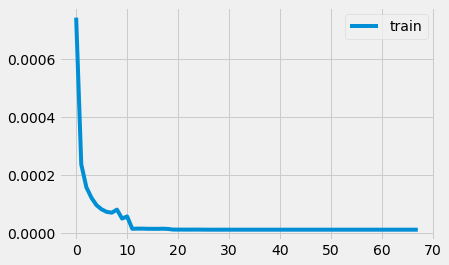

In [23]:
# plot history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
# Create a test data set.
#Test data set
test_data = scaled_data[training_data_len - memory: , : ]
test_data.shape

(850, 7)

In [25]:
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[Y].values[training_data_len :] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data

for i in range(60,len(test_data)):
    x_test.append(test_data[i-memory:i,:])


In [26]:
# Then convert the independent test data set ‘x_test’ to a numpy array so it can be used for testing the LSTM model.
#Convert x_test to a numpy array 
x_test = np.array(x_test)

# Reshape the data to be 3-dimensional in the form [number of samples, number of time steps, and number of features]. This needs to be done, because the LSTM model is expecting a 3-dimensional data set.
#Reshape the data into the shape accepted by the LSTM
# x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],2))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],len(tickers)))

In [27]:
# x_test.shape, x_train.shape
# x_test[0][0]

In [28]:
# x_test[-5:]

In [29]:
# x_test[:, 1:,1].shape
# conc = np.concatenate((predictions, x_test[:, 1:,1]), axis=1)
# predictions.shape, x_test.shape, conc.shape

In [30]:
# Now get the predicted values from the model using the test data.
#Getting the models predicted price values
predictions = model.predict(x_test)
predictions = y_scaler.inverse_transform(predictions) #Undo scaling

# Get the root mean squared error (RMSE), which is a good measure of how accurate the model is. A value of 0 would indicate that the models predicted values match the actual values from the test data set perfectly.
# The lower the value the better the model performed. But usually it is best to use other metrics as well to truly get an idea of how well the model performed.
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

29.746639221062516

In [31]:
# y_test

In [32]:
# predictions
# dataset

C:\Users\szabo\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


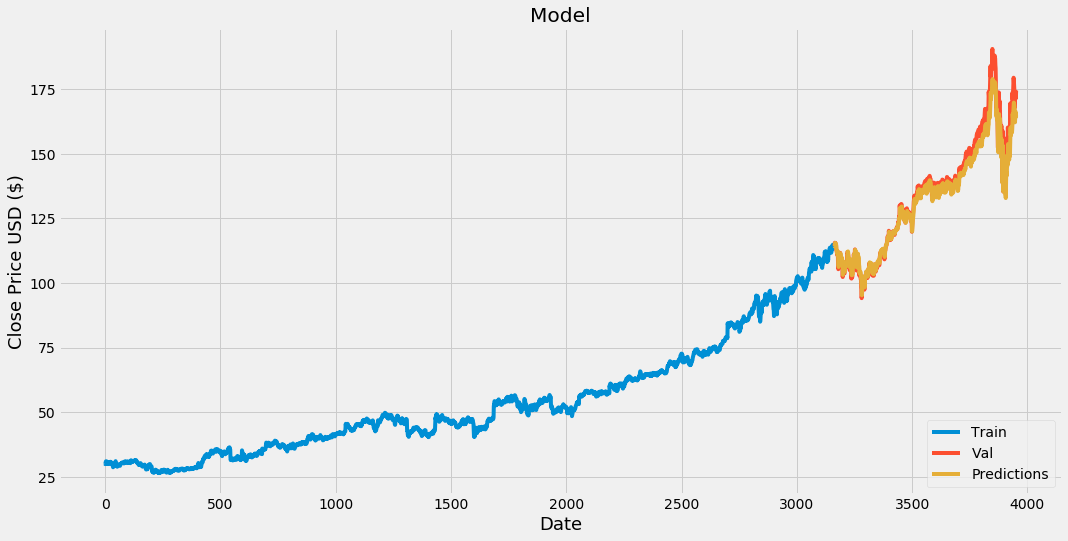

In [33]:
# The RMSE value
# Let’s plot and visualize the data.
#Plot/Create the data for the graph
train = dataset[:training_data_len]
valid = dataset[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train[Y])
plt.plot(valid[[Y, 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

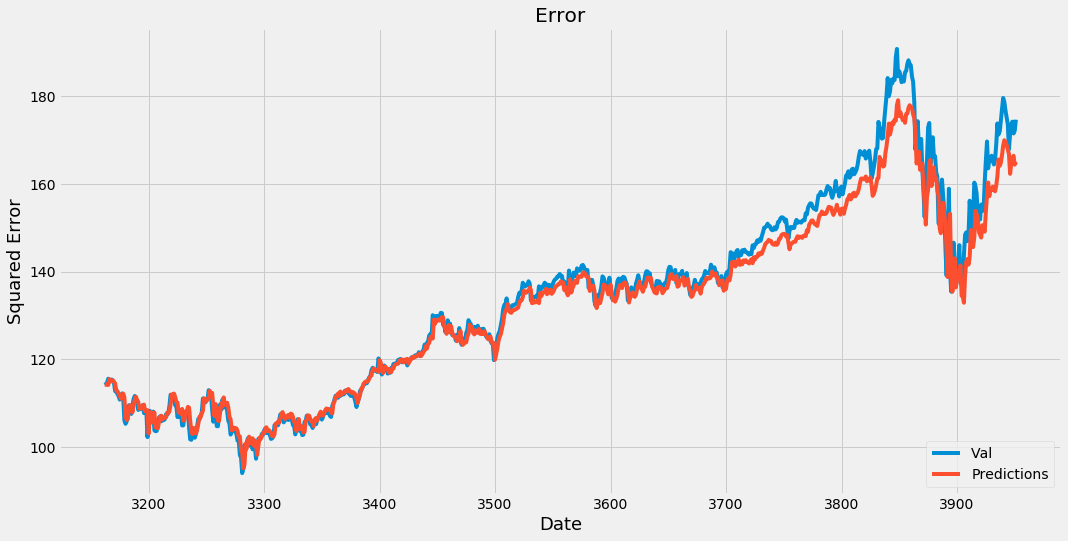

In [34]:
# Graph showing the training (train), actual (valid) and predicted (predictions) prices.
# Show the valid and predicted prices.
#Show the valid and predicted prices
valid.tail()

plt.figure(figsize=(16,8))
plt.title('Error')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Squared Error', fontsize=18)
# plt.plot(valid['Close']-valid['Predictions'])
plt.plot(valid[[Y, 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [35]:
# # The values for actual (close) and predicted (predictions) price.
# # I want to test the model some more and get the predicted closing price value of Apple Inc. for December 18, 2019 (12/18/2019).
# # So I will get the quote, convert the data to an array that contains only the closing price. Then I will get the last 60 day closing price and scale the data to be values between 0 and 1 inclusive.
# # After that I will create an empty list and append the past 60 day price to it, and then convert it to a numpy array and reshape it so that I can input the data into the model.
# # Last but not least, I will input the data into the model and get the predicted price.
# #Get the quote
# apple_quote = web.DataReader(ticker, data_source=data_source, start=start, end=end)
# #Create a new dataframe
# new_df = apple_quote.filter(['Close'])
# #Get teh last 60 day closing price 
# last_60_days = new_df[-60:].values
# #Scale the data to be values between 0 and 1
# last_60_days_scaled = scaler.transform(last_60_days)
# #Create an empty list
# X_test = []
# #Append teh past 60 days
# X_test.append(last_60_days_scaled)
# #Convert the X_test data set to a numpy array
# X_test = np.array(X_test)
# X_test.shape

In [36]:
#Reshape the data
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# X_test.shape

In [37]:
# #Get the predicted scaled price
# pred_price = model.predict(X_test)
# #undo the scaling 
# pred_price = scaler.inverse_transform(pred_price)
# print(pred_price)

# # The predicted price for 12/18/2019
# # Now let’s see what the actual price for that day was.
# #Get the quote
# quote2 = web.DataReader(ticker, data_source=data_source, start=end, end=today)
# print(quote2['Close'])

In [38]:
# simulation
# pred_price


In [ ]:



# def evaluator(predicted = predictions, validation = valid, starting_cash = 1000, bet_bid = 10):
#     validation["cash"] = None
#     for row in validation:
#         if row['cash'] == None:
#             row['cash'] = starting_cash
#         elif row[]
        
start_cash = 1000
# evaluator(validation = valid, starting_cash = 1000, bet_bid = 10)   
calc_df = pd.DataFrame()
# v = valid.loc['2019-08-01':'2019-09-01'][[Y,'Predictions']]
calc_df = valid.loc[:][[Y,'Predictions']]
calc_df.loc[:,"prev_pred"] = calc_df['Predictions'].shift(1)
calc_df.loc[:,"prev_close"] = calc_df[Y].shift(1)
calc_df.loc[:,'pred_growth'] = calc_df['Predictions'] / calc_df["prev_pred"]
calc_df.loc[:,'pred_growth'] = calc_df.loc[:,'pred_growth'].shift(-1)
calc_df.loc[:,'close_growth'] = calc_df[Y] / calc_df["prev_close"]
calc_df.loc[:,'cash'] = '-'
calc_df.loc[:,'bid'] = 0
# v.['date'] = v.index
# v= calc_df.reset_index()
# v = v.fillna(1)

vcols = ['Date', 'Predictions','MSFT','prev_pred','prev_close','pred_growth','close_growth','cash','bid']
# v = v[vcols]


def buy(i, data, balance_col='cash', bid_col='bid'):
    data.loc[i,balance_col] = data.loc[i-1,balance_col]
    data.loc[i,bid_col] = data.loc[i,balance_col]
    data.loc[i,balance_col] = 0


def sell(i, data, balance_col='cash', bid_col='bid', actual_growth = 'close_growth'):
    data.loc[i,balance_col] = data.loc[i-1,bid_col] * data.loc[i,actual_growth]
    data.loc[i,bid_col] = 0
    
def hold_bid(i, data, balance_col='cash', bid_col='bid', actual_growth = 'close_growth'):
    data.loc[i,bid_col] = data.loc[i-1,bid_col] * data.loc[i,actual_growth]
    data.loc[i,balance_col] = 0
    
def hold_cash(i, data, balance_col='cash', bid_col='bid'):
    data.loc[i,balance_col] = data.loc[i-1,balance_col]


# buy_thr = 1.04
# sel_thr = 0.98

opt_buy_thr = '-'
opt_sel_thr = '-'
max_balance = '-'
opt_history = pd.DataFrame()
parameter_hist = {'bt': [],
                 'st':[],
                 'balance':[]}


for buy_thr in np.arange(1,max(calc_df['pred_growth']),(max(calc_df['pred_growth'])-1)/100):
#   print(buy_thr)
    
    for sel_thr in np.arange(min(calc_df['pred_growth']),1,(1-min(calc_df['pred_growth']))/100):
        v = calc_df.reset_index()
        
#         print(buy_thr, sel_thr)
        for i, row in v.iterrows():
            # jelentős növekedés várható
            if i == 0:
                v.loc[i,'cash'] = start_cash
#             elif v.loc[i, 'close_growth']
            if (row['pred_growth'] > buy_thr) and (i > 0):
                # és már van bent bid
                if v.loc[i-1,'bid'] > 0:
                    hold_bid(i, data = v)
        #         ha nincs bent bid -> vétel
                else:
                    buy(i, data = v)    

            # ha jelentős csökkenés várható 
            elif (row['pred_growth'] < sel_thr) and (i > 0):
                # ÉS nincs bent bid akkor cash  =  cash(T-1)
                if v.iloc[i-1]['bid'] <= 0:
#                     print("macska")
                    hold_cash(i, data = v)
                # ÉS van már bent bid akkor ELADÁS
                else:
                    sell(i, data = v)

            # ha semlegesek a várakozások
            elif (row['pred_growth'] <= buy_thr) and (row['pred_growth'] >= sel_thr) and (i > 0):
                # ÉS nincs bent bid akkor cash  =  cash(T-1)
                if v.iloc[i-1]['bid'] <= 0:
                    hold_cash(i, data = v)
                # ÉS van már bent bid akkor NO ACTION
                else:
                    hold_bid(i, data = v)
#         print(v)
        if (v.tail(2).head(1)['bid'].values[0] < v.tail(2).head(1)['cash'].values[0]):
            balance = v.tail(2).head(1)['cash'].values[0]
        else:
            balance = v.tail(2).head(1)['bid'].values[0]
        
        parameter_hist['balance'].append(balance)
        parameter_hist['bt'].append(buy_thr)
        parameter_hist['st'].append(sel_thr)
        
        if max_balance == '-' or max_balance < balance:
            opt_buy_thr = buy_thr
            opt_sel_thr = sel_thr
            max_balance = balance
            opt_history = v
            

# pd.DataFrame.from_dict(parameter_hist)

In [ ]:
# max(valid['Predictions'])
# np.arange(1,max(calc_df['pred_growth']),(max(calc_df['pred_growth'])-1)/2)
# max(calc_df['pred_growth']), (max(calc_df['pred_growth'])-1)/2
# v.loc[i, 'close_growth']
# v[v['pred_growth'].isna()]
# max(calc_df['pred_growth'])

In [ ]:
# v

In [ ]:
# buy_thr, sel_thr

In [ ]:
# v

In [ ]:
# v.loc[0,'cash'] = start_cash
# range(min(v['pred_growth']),1,(1-min(v['pred_growth']))/100)
# np.arange(min(v['pred_growth']),1,(1-min(v['pred_growth']))/100)
# v.tail(2).head(1)['cash'],
# v.tail(2).head(1)['bid'].values[0]
parameter_hist = pd.DataFrame.from_dict(parameter_hist)
# import numpy as np
# import matplotlib.pyplot as plt

# # Generate data...
# x = np.random.random(10)
# y = np.random.random(10)

# Plot...
# plt.scatter(parameter_hist['bt'], parameter_hist['st'], c=parameter_hist['balance'], s=1)
# plt.gray()

# plt.show()
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# zline = np.linspace(0, 15, 1000)
# xline = np.sin(zline)
# yline = np.cos(zline)
# ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
# zdata = 15 * np.random.random(100)
# xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
# ydata = np.cos(zdata) + 0.1 * np.random.randn(100)

# parameter_hist['bt'], parameter_hist['st'], c=parameter_hist['balance']

ax.scatter3D(parameter_hist['bt'], parameter_hist['st'], parameter_hist['balance'], c=parameter_hist['balance'], cmap='Greens');

In [ ]:
f_par_hist = parameter_hist[ #(parameter_hist['balance'] != max(parameter_hist['balance'])) &
              (parameter_hist['st'] > min(parameter_hist['st'])) &
              (parameter_hist['bt'] < max(parameter_hist['bt']))]

pyplot.scatter(f_par_hist['balance'], f_par_hist['bt'], label='bt')
pyplot.scatter(f_par_hist['balance'], f_par_hist['st'], label='st')
# pyplot.plot(parameter_hist['balance'], label='balance')
pyplot.legend()
pyplot.show()

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(f_par_hist['bt'], f_par_hist['st'], c=f_par_hist['balance'], cmap="inferno",s=5)
# pyplot.scatter(f_par_hist['balance'], f_par_hist['st'], label='st')
# pyplot.plot(parameter_hist['balance'], label='balance')
legend1 = ax.legend(*scatter.legend_elements(num=5),
                    loc='lower right', title="Ranking")
ax.add_artist(legend1)
fig.show()

In [ ]:
opt_buy_thr, opt_sel_thr, max_balance 

In [ ]:
# valid.loc['2019-08-08':'2019-08-09'][['MSFT','Predictions']]
# 
# opt_buy_thr, opt_sel_thr, max_balance 
opt_history

In [ ]:
start_cash = 1000
# evaluator(validation = valid, starting_cash = 1000, bet_bid = 10)   
v = pd.DataFrame()
v = valid.loc[:,[Y,'Predictions']]
v.loc[:,"prev_pred"] = v['Predictions'].shift(1)
v.loc[:,"prev_close"] = v[Y].shift(1)
v.loc[:,'pred_growth'] = v['Predictions'] / v["prev_pred"]
v.loc[:,'close_growth'] = v[Y] / v["prev_close"]
v.loc[:,'cash'] = '-'
v.loc[:,'bid'] = 0

In [ ]:
v

In [ ]:
# valid.shape
# v = valid
# v["cash"] = "Something fishy"
# v

